In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.utils import load_img
import os
warnings.filterwarnings('ignore')

### Create dataframe for Images and their Labels

In [2]:
input_path = []
label = []

for class_name in os.listdir('PetImages'):
    for path in os.listdir('PetImages/'+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join('PetImages', class_name, path))


In [3]:
len(input_path)

24961

In [4]:
df = pd.DataFrame()
df['Images'] = input_path
df['Label'] = label

df.head()

Images  Label
0     PetImages\Cat\0.jpg      0
1     PetImages\Cat\1.jpg      0
2    PetImages\Cat\10.jpg      0
3   PetImages\Cat\100.jpg      0
4  PetImages\Cat\1000.jpg      0

In [13]:
# Shuffle data to have a good split
df = df.sample(frac=1).reset_index(drop=True)
df.head()

Images  Label
0   PetImages\Cat\4554.jpg      0
1   PetImages\Dog\8409.jpg      1
2   PetImages\Dog\6971.jpg      1
3   PetImages\Cat\4099.jpg      0
4  PetImages\Dog\10465.jpg      1

# Data Analysis

In [14]:
import random

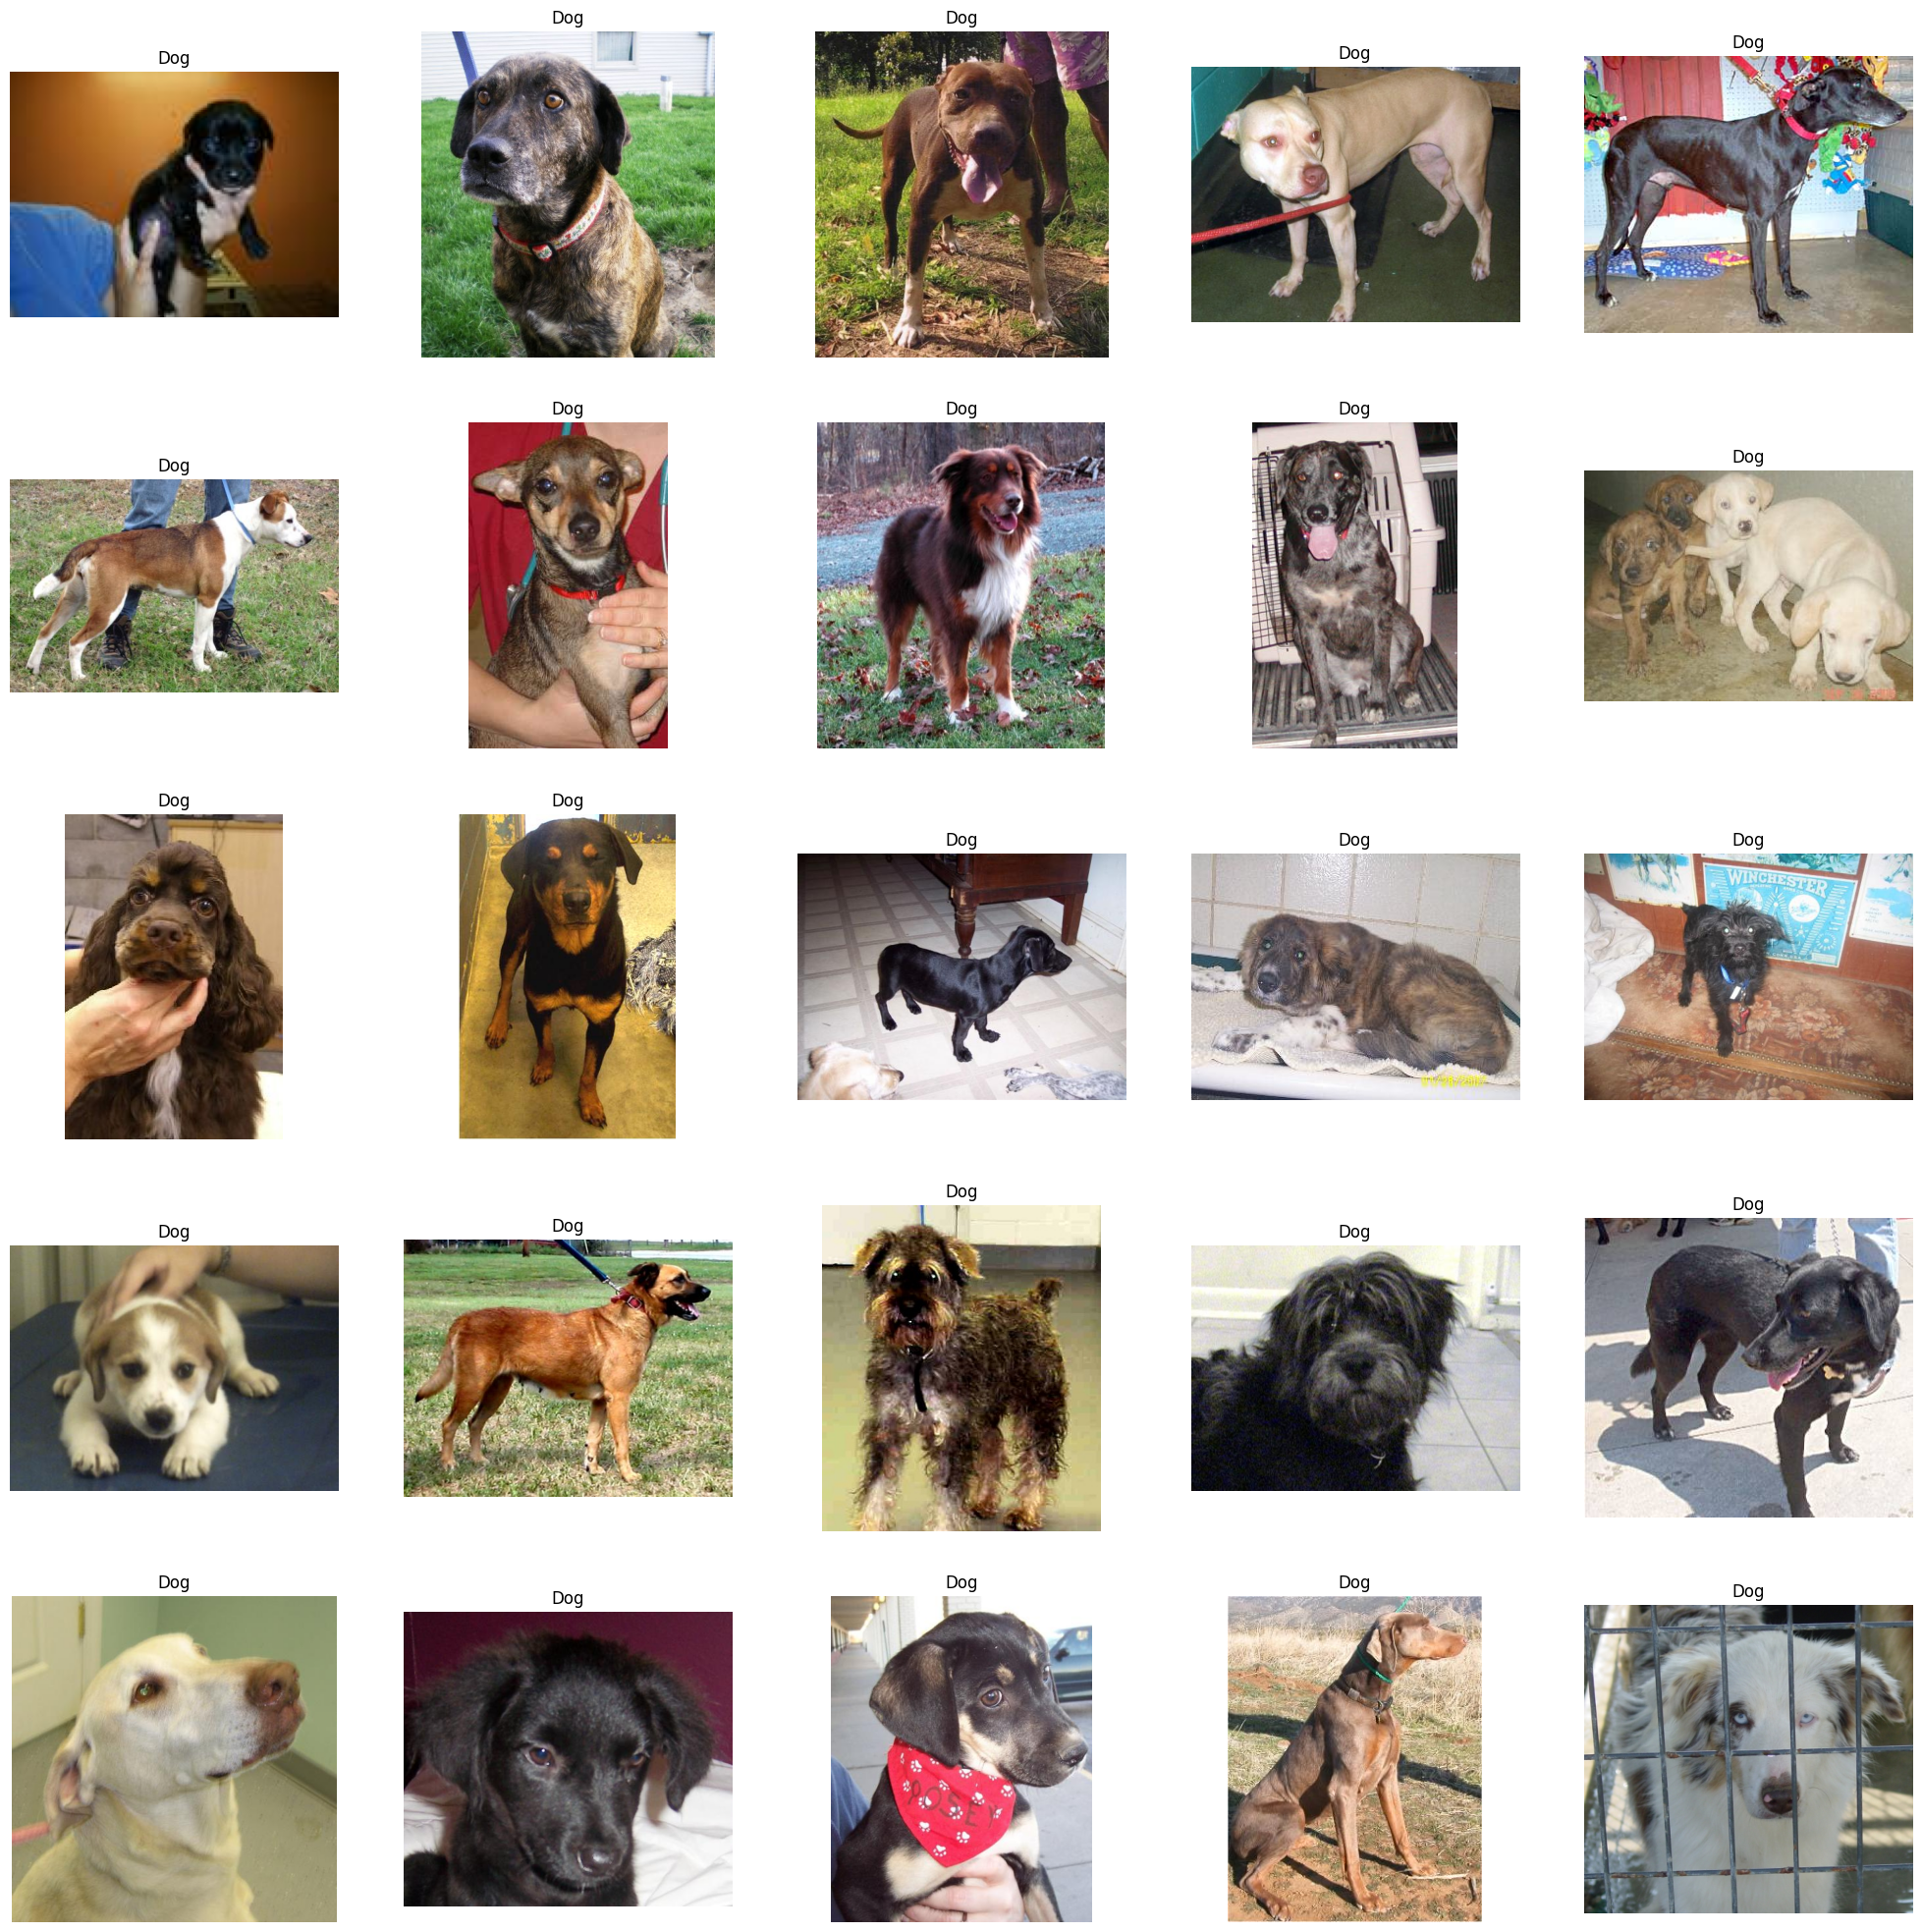

In [16]:
plt.figure(figsize=(25,25))
temp = df[df["Label"] == 1]['Images']
start = random.randint(0, len(temp))

# Here we get any random 25 images from our dataframe
files = temp[start:start+25]

for index , file in enumerate(files):
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dog')
    plt.axis('off')

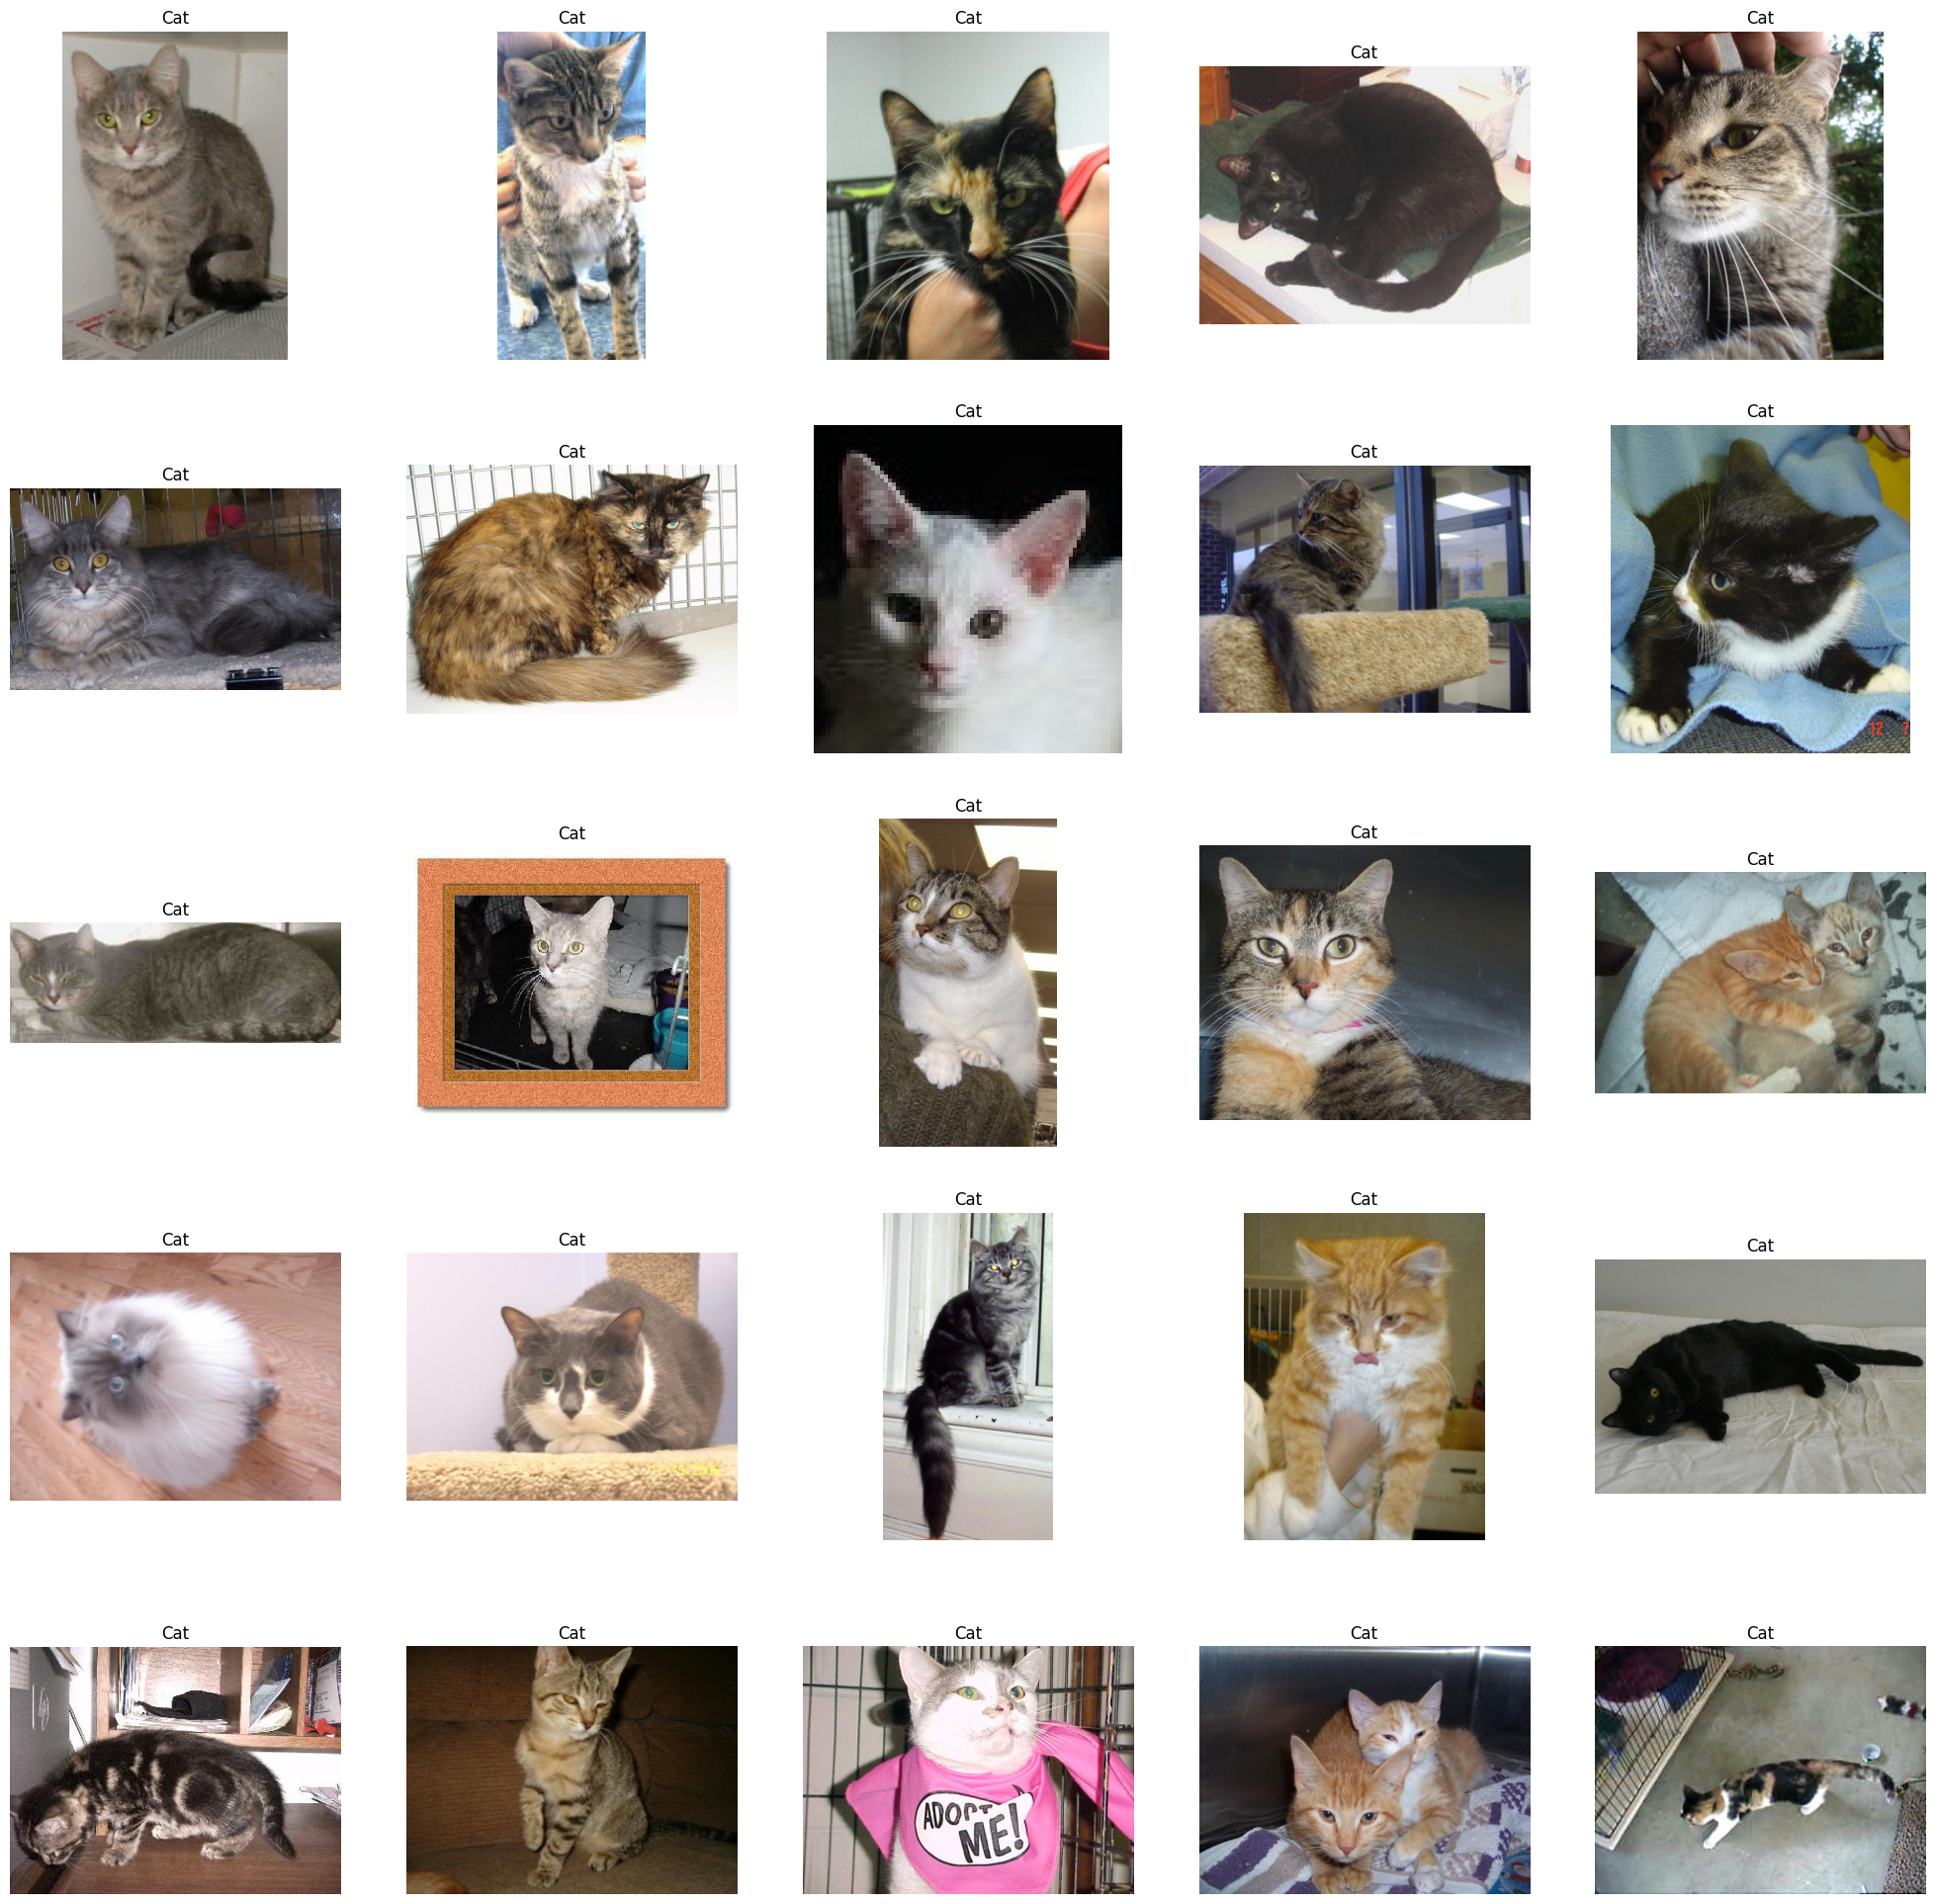

In [17]:
plt.figure(figsize=(25,25))
temp = df[df["Label"] == 0]['Images']
start = random.randint(0, len(temp))

# Here we get any random 25 images from our dataframe
files = temp[start:start+25]

for index , file in enumerate(files):
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cat')
    plt.axis('off')

<Axes: xlabel='Label'>

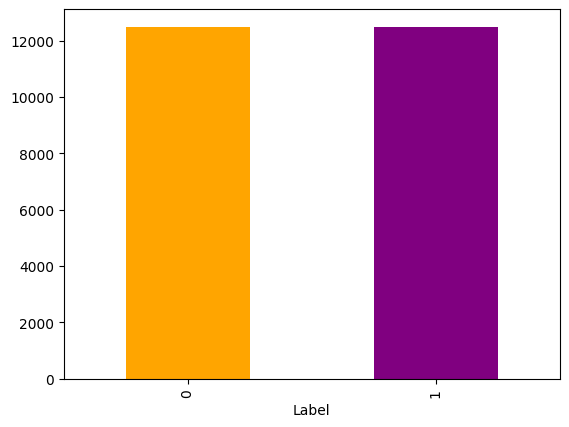

In [18]:
df.Label.value_counts().plot(kind='bar', color=['orange', 'purple'])

# Data Generator for Images

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
# Convert into string for it to work in the train iterator
df['Label'] = df['Label'].astype('str')

### Train Test Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

### Build the generator and iterator for both training and testing dataframes

In [37]:
train_generator = ImageDataGenerator(
    rescale = 1./255,   # Normalization of the images
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_generator = ImageDataGenerator(rescale=1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='Images',
    y_col='Label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='Images',
    y_col='Label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19966 validated image filenames belonging to 2 classes.
Found 4993 validated image filenames belonging to 2 classes.


# Build our Model

In [27]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [30]:
# the input shape represents our image resolutions we mentioned before (128) and the 3 represents our rgb (3, 1 if its greyscale)
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,137 (24.59 MB)

 Trainable params: 6,447,137 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.7345 - loss: 0.5310 - val_accuracy: 0.7362 - val_loss: 0.5255
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7505 - loss: 0.5052 - val_accuracy: 0.7615 - val_loss: 0.4894
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7610 - loss: 0.4891 - val_accuracy: 0.7755 - val_loss: 0.4683
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.7758 - loss: 0.4704 - val_accuracy: 0.7827 - val_loss: 0.4658
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.7734 - loss: 0.4692 - val_accuracy: 0.7913 - val_loss: 0.4472
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7941 - loss: 0.4459 - val_accuracy: 0.7941 - val_loss: 0.4390
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.7915 - loss: 0.4461 - val_accuracy: 0.8077 - val_loss: 0.4177
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7901 - loss: 0.4434 - val_accuracy: 0.7985 - v

# Model Evaluation

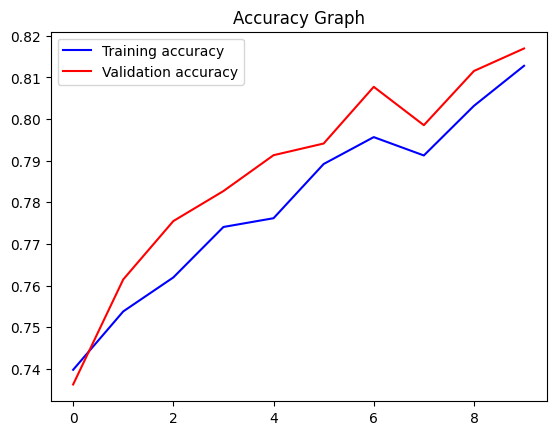

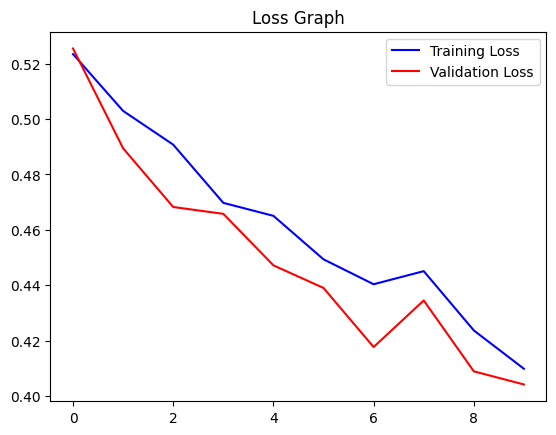

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


In [41]:
model.evaluate(val_iterator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step - accuracy: 0.8106 - loss: 0.4003


[0.404208242893219, 0.8169437050819397]

# Prediction

In [69]:
from tensorflow.keras.preprocessing import image

In [90]:
# Function to get the image as an array, pre-process to get the same dimensions as used in the model
def get_image_array(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape
    img_array /= 255.0  # Normalize the image
    return img_array

In [128]:
# Function to predict the label of the image
def predict_image(model, img_path):
    img_array = get_image_array(img_path)
    prediction = model.predict(img_array)
    predicted_label = 'cat' if prediction < 0.5 else 'dog'
    return predicted_label, prediction

In [129]:
# Change the path accordingly to test out the model
img_path = 'PetImages\\Dog\\227.jpg'

predicted_label, prediction = predict_image(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [130]:
print(f'Predicted Label: {predicted_label}')
print(f'Prediction Confidence: {prediction[0][0]}')

Predicted Label: dog
Prediction Confidence: 0.8922337293624878


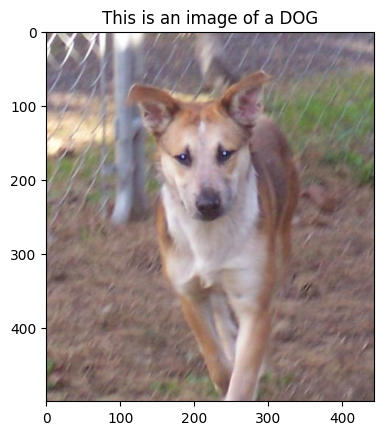

In [131]:
img = image.load_img(img_path)
plt.imshow(img)
plt.title(f'This is an image of a {predicted_label.upper()}')
plt.show()